## What is Propensity Score?

The propensity score is the probability of a unit (e.g., a person, a company) being assigned to a particular treatment given a set of observed covariates. It is used to balance the distribution of observed covariates between treated and control groups in observational studies, helping to reduce bias when estimating causal effects.

Formally, for a binary treatment \( T \) and a set of covariates \( X \), the propensity score \( e(X) \) is defined as:
\[ e(X) = P(T = 1 | X) \]

### Using Propensity Scores for Causal Inference

#### Steps to Implement Propensity Score Methods

1. **Estimate Propensity Scores**:
   Use logistic regression or another suitable model to estimate the probability of treatment assignment based on observed covariates.

2. **Check Overlap**:
   Ensure that there is common support, meaning that for all values of the propensity score, there are both treated and control units.

3. **Balance Covariates**:
   Assess whether the covariates are balanced between treated and control groups after matching, weighting, or stratifying on the propensity score.

4. **Estimate Treatment Effect**:
   Use the propensity scores to adjust for confounding and estimate the causal effect of the treatment.

### Common Methods Using Propensity Scores

1. **Matching**:
   Pair treated units with control units that have similar propensity scores.

2. **Stratification**:
   Divide the sample into strata (e.g., quintiles) based on propensity scores and compare outcomes within each stratum.

3. **Inverse Probability Weighting (IPW)**:
   Weight units by the inverse of their probability of receiving the treatment they actually received to create a pseudo-population in which the treatment is independent of covariates.

4. **Covariate Adjustment**:
   Include the propensity score as a covariate in regression models.

### Example: The NSW job training program

### Introduction to the NSW Job Training Program

The NSW (New South Wales) Job Training Program, also known as the National Supported Work (NSW) Demonstration, was a landmark study conducted in the United States during the 1970s. The program aimed to evaluate the impact of job training on the employment outcomes of disadvantaged workers, including individuals who were long-term unemployed, ex-addicts, ex-offenders, and welfare recipients.

#### Key Features of the NSW Job Training Program

1. **Target Population**: The program focused on individuals who faced significant barriers to employment, providing a unique opportunity to study the effects of intensive job training on marginalized groups.

2. **Randomized Controlled Trial (RCT)**: The study employed a randomized controlled trial design, where participants were randomly assigned to either a treatment group, which received job training, or a control group, which did not. This design is considered the gold standard for evaluating causal effects.

3. **Comprehensive Training**: The job training provided under the NSW program was comprehensive, including elements such as on-the-job training, vocational training, and supportive services to address personal and logistical barriers to employment.

4. **Longitudinal Study**: Participants were tracked over a period of time to assess long-term outcomes, allowing researchers to evaluate not just immediate impacts but also sustained effects of the training.

5. **Key Outcomes**: The primary outcomes of interest were employment status, earnings, and job stability. The study sought to determine whether the job training led to significant improvements in these areas compared to the control group.

In [4]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalinference import CausalModel

from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as p
import graphviz as gr



In [6]:
# URL to the NSW data file
url = "https://github.com/scunning1975/mixtape/raw/master/nsw_mixtape.dta"

# read the NSW into a dataframe
nsw_dw = pd.read_stata(url)
nsw_dw.head()

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [8]:
# URL to the CPS data file
url2 = "https://github.com/scunning1975/mixtape/raw/master/cps_mixtape.dta"

# read the CPS into a dataframe
cps_control = pd.read_stata(url2)
cps_control.head()

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,CPS1,0,45,11,0,0,1,1,21516.669922,25243.550781,25564.669922
1,CPS1,0,21,14,0,0,0,0,3175.970947,5852.564941,13496.080078
2,CPS1,0,38,12,0,0,1,0,23039.019531,25130.759766,25564.669922
3,CPS1,0,48,6,0,0,1,1,24994.369141,25243.550781,25564.669922
4,CPS1,0,18,8,0,0,1,1,1669.295044,10727.610352,9860.869141


In [9]:
# Combine the data
nsw_dw_cpscontrol = pd.concat((cps_control, nsw_dw))
nsw_dw_cpscontrol['u74'], nsw_dw_cpscontrol['u75'] = 0, 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1

### ATE
NSW was a randomized job-training program; therefore, the independence assumption was satisfied. So calculating average treatment effects was straightforward—it’s the simple difference in means estimator

In [7]:
mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.34


Using the above code, we calculate that the NSW job-training program caused real earnings in 1978 to increase by $1,794.34

## Propensity score
Rather than using the experimental control group from the original randomized experiment, we will use the non-experimental control group from the Current Population Survey. It is very important to stress that while the treatment group is an experimental group, the control group now consists of a random sample of Americans from that time period. Thus, the control group suffers from extreme selection bias since most Americans would not function as counterfactuals for the distressed group of workers who selected into the NSW program. In the following, we will append the CPS data to the experimental data and estimate the propensity score using logit

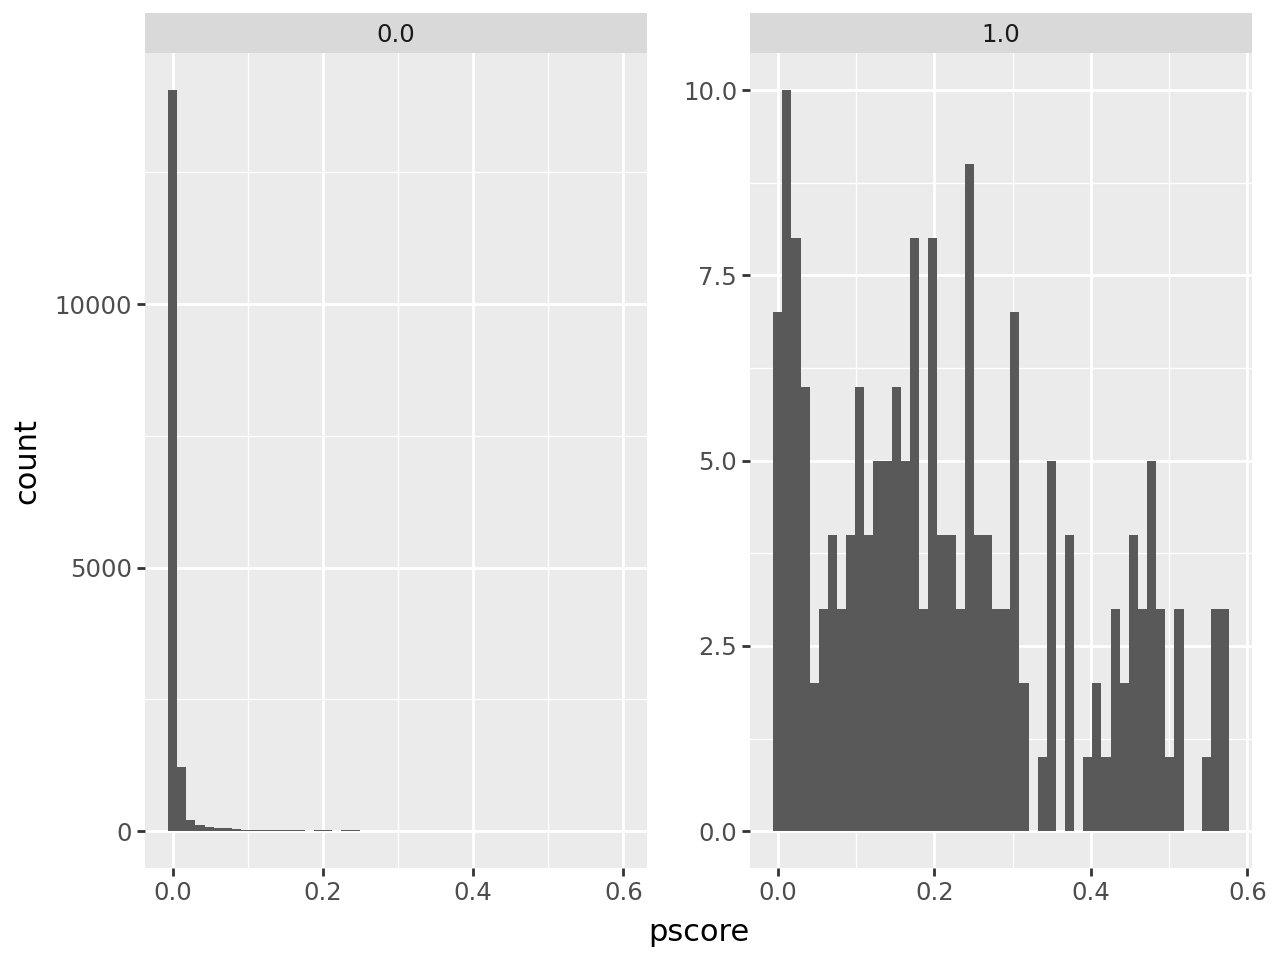

In [15]:
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)

nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

p.ggplot(nsw_dw_cpscontrol, p.aes(x='pscore')) + p.geom_histogram(bins=50) + p.facet_wrap("treat", scales='free')

These two simple diagnostic tests show what is going to be a problem later when we use inverse probability weighting. The probability of treatment is spread out across the units in the treatment group, but there is a very large mass of nearly zero propensity scores in the CPS. 

### Weighting on the propensity score
inverse probability weighting

In [18]:

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol = nsw_dw_cpscontrol 
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol['d1'] * nsw_dw_cpscontrol.re78
nsw_dw_cpscontrol['y0'] = nsw_dw_cpscontrol['d0'] * nsw_dw_cpscontrol.re78 
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        

Treatment Effect (non-normalized, all data): -12504.90


In [20]:
N = nsw_dw_cpscontrol.shape[0]

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))

Treatment Effect (normalized, all data): -7278.86


When we estimate the treatment effect using inverse probability weighting using the non-normalized weighting procedure described earlier, we find an estimated ATT of -12504.90. Using the normalization of the weights, we get -7278.86. Why is this so much different than what we get using the experimental data?

Recall what inverse probability weighting is doing. It is weighting treatment and control units according to $\hat{p}(X)$, which is causing units with very small values of the propensity score to blow up and become unusually influential in the calculation of ATT. Thus, we will need to trim the data. Here we will do a very small trim to eliminate the mass of values at the far-left tail. Crump et al. (2009) develop a principled method for addressing a lack of overlap. A good rule of thumb, they note, is to keep only observations on the interval [0.1,0.9], which was performed at the end of the program.

In [21]:
nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))

Treatment Effect (non-normalized, trimmed data): 2294.72


In [23]:
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (normalized, trimmed data): 578.35


## Propensity Score Matching

In [24]:
smf.ols("re78 ~ treat + pscore", data=nsw_dw_cpscontrol).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.503e+04,75.827,198.174,0.000,1.49e+04,1.52e+04
treat,-38.7737,780.972,-0.050,0.960,-1569.564,1492.017
pscore,-3.894e+04,1606.261,-24.243,0.000,-4.21e+04,-3.58e+04


In [25]:
smf.ols("re78 ~ treat + pscore", data=nsw_dw_trimmed).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4857.5087,661.550,7.343,0.000,3557.773,6157.245
treat,1778.7568,659.281,2.698,0.007,483.479,3074.035
pscore,-2282.0392,2237.836,-1.020,0.308,-6678.675,2114.597


In [26]:
cm = CausalModel(
    Y=nsw_dw_trimmed["re78"].values, 
    D=nsw_dw_trimmed["treat"].values, 
    X=nsw_dw_trimmed[["pscore"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    871.791   1117.567      0.780      0.435  -1318.640   3062.223
           ATC    420.143   1214.664      0.346      0.729  -1960.598   2800.884
           ATT   2091.572   1175.591      1.779      0.075   -212.587   4395.731



C:\Users\chaiy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
